# Oil Production Forecasting (Time Series) - Kaggle

## 1. Goal
 Predict the first three years cum of a producing well starting from peak of production.

## 2. Datasets
- Harmony_data.csv - file contains a batch of features for both the training and test sets
- IHS_data.csv - file contains another batch of features for both the training and test sets
- test_APIs.csv - contains list of APIs you'll use for the test set
- sampleSubmission.csv - a sample submission file in the correct format
- production_data_train.csv - production data for the training set
- production_data_test.csv - production data for the test set

## 3. Evaluation 
Submissions are evaluated using the mean absolute error between the predicted and actual three years cumulative production. MAE measures the average magnitude of the errors in a set of predictions, without considering their direction.

## 4. Import all necessry libraries

In [290]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.graphics.tsaplots as sgt 
import statsmodels.tsa.stattools as sts 
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA, ARIMAResults
from statsmodels.tsa.arima_process import ArmaProcess
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pmdarima.arima import auto_arima
from pmdarima.arima import OCSBTest
from cycler import cycler
from datetime import datetime
from dateutil.relativedelta import relativedelta
import xgboost as xgb
from sklearn.metrics import mean_squared_error, max_error

## 5. Exploratory Data Analysis

In [2]:
harmony_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Harmony_data.csv')
IHS_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\IHS_data.csv')
train_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_train.csv', parse_dates=[['Month', 'Year']])
test_data = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\production_data_test.csv', parse_dates=['date'])
test_APIs = pd.read_csv(r'C:\Users\USUARIO\Documents\GitHub\Oil-Gas-Projects\Reservoir Engineering\Datasets\Oil Production\Test_APIs.csv')
test_APIs.shape, harmony_data.shape, IHS_data.shape, train_data.shape, test_data.shape,

((1134, 1), (8930, 7), (9224, 14), (394074, 9), (6489, 11))

In [3]:
harmony_data.head(3)

,API,LATERAL_LENGTH_BLEND,PROP_PER_FOOT,WATER_PER_FOOT,GOR_30,GOR_60,GOR_90
0,5123371740000,9056,1025.8680,790.7205,2300.919963,2290.231375,2171.635752
1,5123377360000,4101,NaN,NaN,3786.669639,3838.096579,4012.142621
2,5123378210000,4161,916.0801,839.9280,2399.490505,2291.864862,2472.275585


In [4]:
IHS_data.head(2)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
0,33105037530000,2014-09-10,2014-12-31,2015-05-05,2015-03-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.227596,-103.299600,48.2546,-103.29997
1,33105032020000,2013-09-09,2013-11-02,2014-04-28,2014-04-01 00:00:00.000,CONTINENTAL RESOURCES INCORPORATED,BAKKEN,WILLISTON BASIN,NORTH DAKOTA,WILLIAMS,48.230954,-103.189754,48.1983,-103.19195


In [5]:
train_data.head(2)

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
0,2015-03-01,33053063590000,17186,26624,1.549168,8213,0.477889,16,2016-08-11 14:03:14.000
1,2015-04-01,33053063590000,18796,21796,1.159608,7255,0.385986,30,2016-08-11 14:03:14.000


In [6]:
test_data.head(2)

,API,Year,Month,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate,date
0,33053052530100,2014,7,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990,2014-07-01
1,33053052530100,2014,8,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990,2014-08-01


In [7]:
train_data.Month_Year.describe(datetime_is_numeric=True)

count                           394074
mean     2016-10-08 05:38:51.759010048
min                1977-10-01 00:00:00
25%                2015-11-01 00:00:00
50%                2016-11-01 00:00:00
75%                2017-12-01 00:00:00
max                2019-02-01 00:00:00
Name: Month_Year, dtype: object

In [8]:
test_data.date.describe(datetime_is_numeric=True)

count                             6489
mean     2015-08-12 07:16:43.606102528
min                2008-09-01 00:00:00
25%                2014-11-01 00:00:00
50%                2015-05-01 00:00:00
75%                2016-01-01 00:00:00
max                2019-01-01 00:00:00
Name: date, dtype: object

In [9]:
test_data.set_index('date', inplace=True)
test_data.drop(['Year','Month'], axis=1, inplace=True)

In [10]:
test_data.head(2)

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2014-07-01,33053052530100,19518,34414,1.763193,10786,0.552618,31,2016-04-06 13:48:08.990
2014-08-01,33053052530100,18632,32250,1.730893,9959,0.534511,31,2016-04-06 13:48:08.990


In [11]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 394074 entries, 0 to 394073
Data columns (total 9 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Month_Year    394074 non-null  datetime64[ns]
 1   API           394074 non-null  int64         
 2   Liquid        394074 non-null  int64         
 3   Gas           394074 non-null  int64         
 4   RatioGasOil   394074 non-null  float64       
 5   Water         394074 non-null  int64         
 6   PercentWater  394074 non-null  float64       
 7   DaysOn        394074 non-null  int64         
 8   _LastUpdate   394074 non-null  object        
dtypes: datetime64[ns](1), float64(2), int64(5), object(1)
memory usage: 27.1+ MB


#### Checking null values

In [12]:
# Check for missing values
train_data.isnull().sum()

Month_Year      0
API             0
Liquid          0
Gas             0
RatioGasOil     0
Water           0
PercentWater    0
DaysOn          0
_LastUpdate     0
dtype: int64

In [13]:
IHS_data.isnull().sum()

API                      0
PermitDate               0
SpudDate                 0
CompletionDate           0
FirstProductionDate    183
operatorNameIHS          0
formation                0
BasinName                0
StateName                0
CountyName               0
LatWGS84                 0
LonWGS84                 0
BottomHoleLatitude       0
BottomHoleLongitude      0
dtype: int64

In [14]:
harmony_data.isnull().sum()

API                       0
LATERAL_LENGTH_BLEND      0
PROP_PER_FOOT           460
WATER_PER_FOOT          633
GOR_30                  135
GOR_60                  135
GOR_90                  135
dtype: int64

### Compare the number of wells

In [15]:
# IHS_data Number of wells
IHS_data.API.unique().shape

(8930,)

In [16]:
# Harmony_data Number of wells
harmony_data.API.unique().shape

(8930,)

In [17]:
# Train_data + test_data number of wells
train_data.API.unique().shape[0] + test_data.API.unique().shape[0]

8973

In [18]:
# test_data Number of wells
test_data.API.unique().shape

(1129,)

In [19]:
# Get repetead wells in train and test data
repetead_wells = []
for well in train_data.API.unique():
    if well in test_data.API.unique():
        repetead_wells.append(well)

print(len(repetead_wells))

43


In [20]:
# Count the number of total wells without repetead
train_data = train_data[~train_data.API.isin(repetead_wells)]
train_data.API.unique().shape[0] + test_data.API.unique().shape[0]

8930

#### Check values of each column

In [21]:
# Compare the same WELL in test and test data
train_data[(train_data['API']) == 42301322730000][5:10]

,Month_Year,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate


In [22]:
# Compare the same WELL in test and test data
test_data[(test_data['API'] == 42301322730000)]

,API,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,_LastUpdate
date,,,,,,,,
2015-02-01,42301322730000,10801,36697,3.397556,31584,2.924174,0,2018-11-04 10:19:16.577
2015-03-01,42301322730000,17497,78231,4.471109,67331,3.848145,0,2018-11-04 10:19:16.577
2015-04-01,42301322730000,12283,65415,5.325653,56301,4.583652,0,2018-11-04 10:19:16.577
2015-05-01,42301322730000,9661,64795,6.706863,55767,5.772384,0,2018-11-04 10:19:16.577


In [23]:
# Check if all the wells in test data are in harmony_data and IHS_data
set(test_APIs.index.unique()) - set(harmony_data.index.unique()), set(test_APIs.index.unique()) - set(IHS_data.index.unique())

(set(), set())

In [24]:
# IHS data has more observations than harmony data and wells, it is necessary to verify data that are duplicated 
IHS_data[IHS_data.API.isin(list(IHS_data.API[IHS_data.API.duplicated()]))].head(3)

,API,PermitDate,SpudDate,CompletionDate,FirstProductionDate,operatorNameIHS,formation,BasinName,StateName,CountyName,LatWGS84,LonWGS84,BottomHoleLatitude,BottomHoleLongitude
272,42301320940000,2014-01-02,2014-02-19,2014-04-17,NaN,WPX ENERGY PRODUCTION LLC,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.942399,-103.870208,31.95571,-103.86969
281,42301322750000,2014-08-09,2015-04-08,2015-07-21,NaN,EOG RESOURCES INCORPORATED,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.971822,-103.626594,31.95668,-103.62589
289,42301323710000,2014-10-10,2014-12-18,2015-05-27,2016-01-01 00:00:00.000,APACHE CORPORATION,BONE SPRING,PERMIAN BASIN,TEXAS,LOVING,31.751439,-103.614968,31.73676,-103.63004


In [25]:
# Drop duplicated wells in IHS data
IHS_data_nd = IHS_data.drop_duplicates(subset=['API']).reset_index()
IHS_data_nd.shape

(8930, 15)

### Map well features into train and data sets

In [26]:
# Map the IHS_data to train_dat and test_data
for column in IHS_data_nd.columns:
    train_data[column + '_new'] = train_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

for column in IHS_data_nd.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(IHS_data_nd.API, IHS_data_nd[column])))

In [27]:
# Map the harmony_data to the test_data
for column in harmony_data.columns:
    train_data[column + '_new'] = train_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

for column in harmony_data.columns:
    test_data[column + '_new'] = test_data['API'].map(dict(zip(harmony_data.API, harmony_data[column])))

In [28]:
# Drop columns with no relevance
train_df = train_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)
test_df = test_data.drop(['index_new', 'API_new','PermitDate_new','FirstProductionDate_new','SpudDate_new','CompletionDate_new','LatWGS84_new','LonWGS84_new', 'GOR_30_new', 'GOR_60_new', 'GOR_90_new', '_LastUpdate'], axis=1)

In [29]:
# Rename date column to match test_data
train_df.rename(columns={'Month_Year':'date'}, inplace=True)

In [30]:
# Set date as index
train_df.set_index('date', inplace=True)

In [31]:
# Check if test_df and test_df have the same columns
set(train_df.columns) - set(test_df.columns)

set()

### Plot some random wells

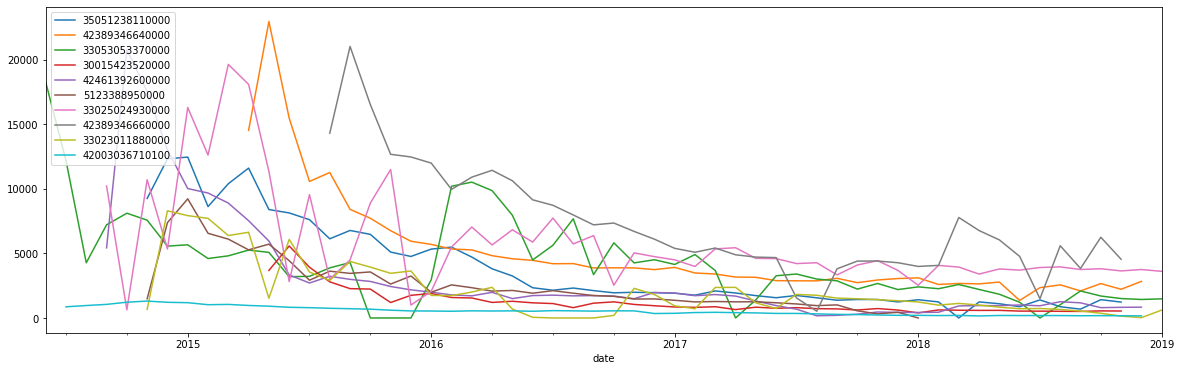

In [32]:
# Plot some random wells from train_df to see their behaviour
np.random.seed(82)
random_wells = np.random.choice(train_df.API.unique(), 10)

for well in random_wells:
    train_df[(train_df['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y']))) 
plt.legend(random_wells, loc='upper left')
plt.show()

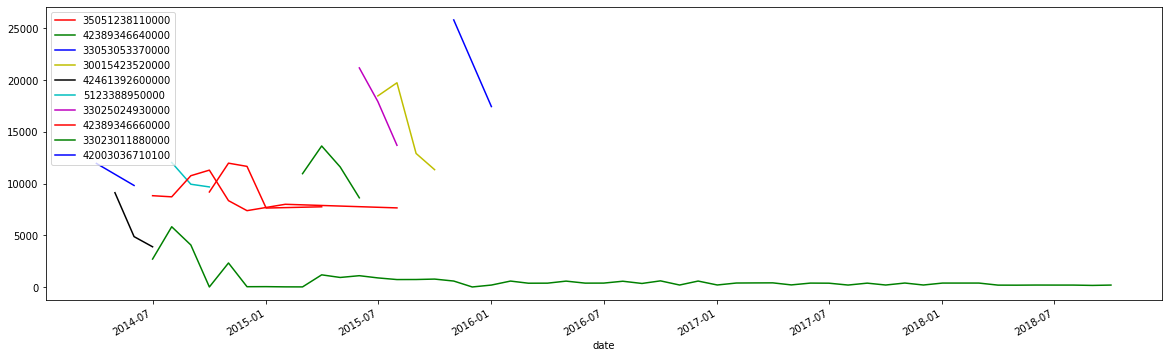

In [33]:
# Plot some random wells from test_df to see their behaviour
random_wells_test = np.random.choice(test_df.API.unique(), 10)

for well in random_wells_test:
    test_df[(test_df['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y']))) 
plt.legend(random_wells, loc='upper left')
plt.show()

### Cleaning up data

In [34]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 391929 entries, 2015-03-01 to 2018-09-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       391929 non-null  int64  
 1   Liquid                    391929 non-null  int64  
 2   Gas                       391929 non-null  int64  
 3   RatioGasOil               391929 non-null  float64
 4   Water                     391929 non-null  int64  
 5   PercentWater              391929 non-null  float64
 6   DaysOn                    391929 non-null  int64  
 7   operatorNameIHS_new       391929 non-null  object 
 8   formation_new             391929 non-null  object 
 9   BasinName_new             391929 non-null  object 
 10  StateName_new             391929 non-null  object 
 11  CountyName_new            391929 non-null  object 
 12  BottomHoleLatitude_new    391929 non-null  float64
 13  BottomHoleLongitude_new   39

In [35]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 6489 entries, 2014-07-01 to 2015-03-01
Data columns (total 17 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   API                       6489 non-null   int64  
 1   Liquid                    6489 non-null   int64  
 2   Gas                       6489 non-null   int64  
 3   RatioGasOil               6489 non-null   float64
 4   Water                     6489 non-null   int64  
 5   PercentWater              6489 non-null   float64
 6   DaysOn                    6489 non-null   int64  
 7   operatorNameIHS_new       6489 non-null   object 
 8   formation_new             6489 non-null   object 
 9   BasinName_new             6489 non-null   object 
 10  StateName_new             6489 non-null   object 
 11  CountyName_new            6489 non-null   object 
 12  BottomHoleLatitude_new    6489 non-null   float64
 13  BottomHoleLongitude_new   6489 non-null   flo

In [36]:
# Check the features with missing values
train_df[train_df.PROP_PER_FOOT_new.isnull()].groupby('API').mean()[:3]

,Liquid,Gas,RatioGasOil,Water,PercentWater,DaysOn,BottomHoleLatitude_new,BottomHoleLongitude_new,LATERAL_LENGTH_BLEND_new,PROP_PER_FOOT_new,WATER_PER_FOOT_new
API,,,,,,,,,,,
5001097800000,307.812500,363.312500,1.148123,647.104167,1.172769,27.666667,39.92629,-104.71585,3983.0,NaN,NaN
5001097830000,317.472727,823.890909,1.874774,328.090909,0.455979,26.018182,39.92745,-104.71586,4027.0,NaN,NaN
5001098450000,4648.595238,11096.666667,3.275740,226.880952,0.057842,21.619048,39.95921,-104.84774,4315.0,NaN,NaN


In [37]:
# Check for duplicated values and get rid of them
train_df['I+API'] = train_df.index.astype(str) + train_df.API.astype(str)
test_df['I+API'] = test_df.index.astype(str) + test_df.API.astype(str)

train_df.drop_duplicates(subset=['I+API'], keep='last' ,inplace=True)
test_df.drop_duplicates(subset=['I+API'], keep='last',inplace=True)

In [38]:
# Check number of wells in test set are in test_APIs
set(test_APIs['API']) - set(test_df['API']) # One is not in the test set

{42301320120000}

In [39]:
# Concatenate missing test_APIs from train_df into test_df set and drop from train_df set
test_df = pd.concat([test_df, train_df[(train_df.API == 42301320120000)]], axis=0)
train_df = train_df[~(train_df.API == 42301320120000)]

In [40]:
test_df.shape, train_df.shape

((6549, 18), (391859, 18))

### Sorting the data by test_APIs order

In [41]:
# Sort the test set based onto test_APIs
test_sorted = pd.DataFrame(columns=test_df.columns)

for well in test_APIs.API.unique():
    test_sorted = pd.concat([test_sorted, test_df[(test_df.API == well)]], axis=0)

In [42]:
# Concatenate train_df and test_df
df = pd.concat([train_df, test_sorted], axis=0)

In [43]:
# Fill the missing values with the bfill method
df.fillna(method='bfill', inplace=True)

In [44]:
# Change API column to string
df['API'] = df['API'].astype(str)

In [45]:
df.shape

(398408, 18)

### Transform features into categorical variables

In [46]:
# Function that transform object variables into categorical variables
def transform_object_variables(df):
    for label, content in df.items():
        if content.dtype == 'object':
            df[label] = pd.Categorical(content).codes + 1

In [47]:
transform_object_variables(df)

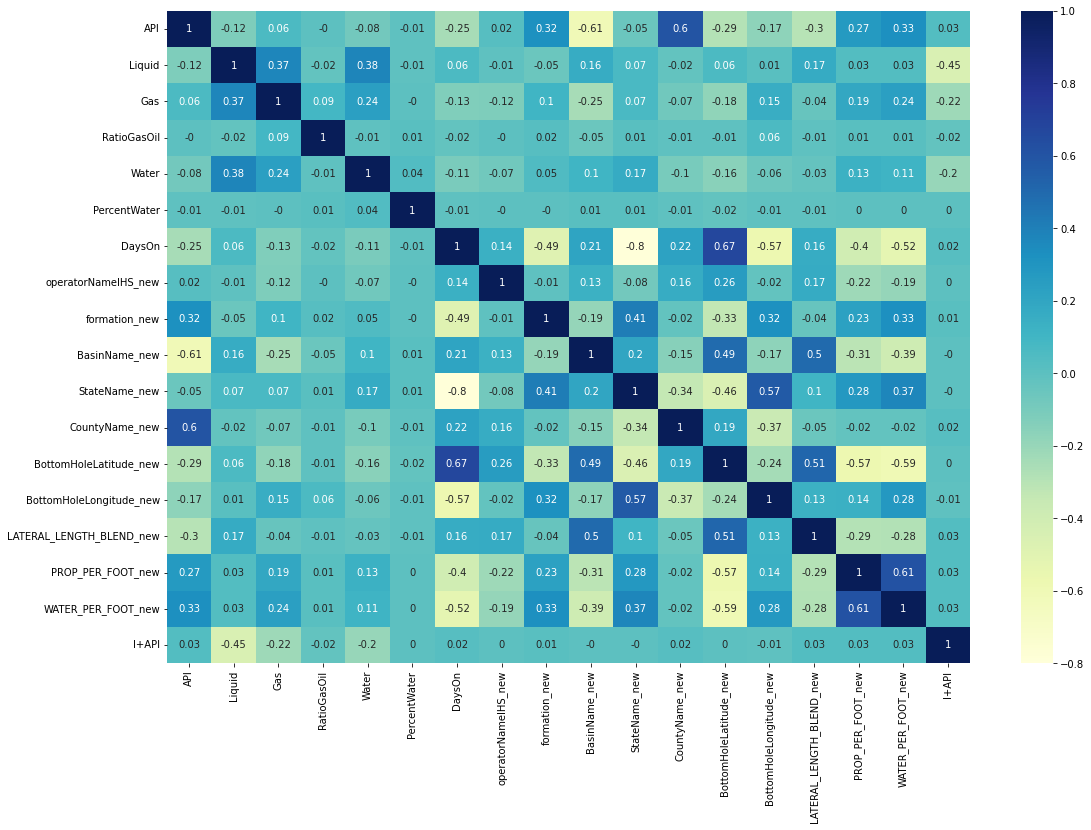

In [48]:
# Plotting correlation matrix
plt.figure(figsize=(18, 12))
sns.heatmap(round(df.corr(),2), annot=True, cmap='YlGnBu');

In [49]:
df.drop(['Gas','RatioGasOil','Water', 'I+API', 'PercentWater', 'DaysOn'], axis=1, inplace=True)

In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398408 entries, 2015-03-01 to 2015-09-01
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype  
---  ------                    --------------   -----  
 0   API                       398408 non-null  int16  
 1   Liquid                    398408 non-null  int64  
 2   operatorNameIHS_new       398408 non-null  int16  
 3   formation_new             398408 non-null  int8   
 4   BasinName_new             398408 non-null  int8   
 5   StateName_new             398408 non-null  int8   
 6   CountyName_new            398408 non-null  int8   
 7   BottomHoleLatitude_new    398408 non-null  float64
 8   BottomHoleLongitude_new   398408 non-null  float64
 9   LATERAL_LENGTH_BLEND_new  398408 non-null  int64  
 10  PROP_PER_FOOT_new         398408 non-null  float64
 11  WATER_PER_FOOT_new        398408 non-null  float64
dtypes: float64(4), int16(2), int64(2), int8(4)
memory usage: 24.3 MB


In [51]:
# Check if there are any duplicated values since train_df and test_df were concataned and drop duplicates keeping the last one(test_df)
df['I+API'] = df.index.astype(str) + df.API.astype(str)
df.drop_duplicates(subset=['I+API'], keep='last', inplace=True)
df.drop(['I+API'], axis=1, inplace=True)

In [52]:
df.reset_index(inplace=True)

### Sort by values by descending date, filter data to start from the peak adn drop NaN

In [53]:
# Sort values by date descending first
data = pd.DataFrame(columns=df.columns)
for well in df.API.unique():
    order = df[(df['API'] == well)].sort_values(by='index')
    data = pd.concat([data, order], axis=0)

In [54]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 398408 entries, 0 to 398407
Data columns (total 13 columns):
 #   Column                    Non-Null Count   Dtype 
---  ------                    --------------   ----- 
 0   index                     398408 non-null  object
 1   API                       398408 non-null  object
 2   Liquid                    398408 non-null  object
 3   operatorNameIHS_new       398408 non-null  object
 4   formation_new             398408 non-null  object
 5   BasinName_new             398408 non-null  object
 6   StateName_new             398408 non-null  object
 7   CountyName_new            398408 non-null  object
 8   BottomHoleLatitude_new    398408 non-null  object
 9   BottomHoleLongitude_new   398408 non-null  object
 10  LATERAL_LENGTH_BLEND_new  398408 non-null  object
 11  PROP_PER_FOOT_new         398408 non-null  object
 12  WATER_PER_FOOT_new        398408 non-null  object
dtypes: object(13)
memory usage: 42.6+ MB


In [55]:
# Set column index as datetime
data['index'] = pd.to_datetime(data['index'])

In [56]:
# Set as index and drop the column
data.set_index(data['index'], inplace=True)
data.drop(['index'], axis=1, inplace=True)

In [57]:
# Make a copy of the dataset
df_filter = data.copy()

In [58]:
# Transform the columns as integers
for column in df_filter.columns:
    df_filter[column] = df_filter[column].astype(int)

df_filter.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 398408 entries, 2015-03-01 to 2015-09-01
Data columns (total 12 columns):
 #   Column                    Non-Null Count   Dtype
---  ------                    --------------   -----
 0   API                       398408 non-null  int32
 1   Liquid                    398408 non-null  int32
 2   operatorNameIHS_new       398408 non-null  int32
 3   formation_new             398408 non-null  int32
 4   BasinName_new             398408 non-null  int32
 5   StateName_new             398408 non-null  int32
 6   CountyName_new            398408 non-null  int32
 7   BottomHoleLatitude_new    398408 non-null  int32
 8   BottomHoleLongitude_new   398408 non-null  int32
 9   LATERAL_LENGTH_BLEND_new  398408 non-null  int32
 10  PROP_PER_FOOT_new         398408 non-null  int32
 11  WATER_PER_FOOT_new        398408 non-null  int32
dtypes: int32(12)
memory usage: 21.3 MB


In [59]:
# Filter out all wells from the peak forward and dropna
for well in df_filter.API.unique():
    df_filter[(df_filter.API == well)] = df_filter[(df_filter.API == well) & (df_filter.index >= df_filter[(df_filter.API == well)].Liquid.idxmax())]

df_filter.dropna(inplace=True)

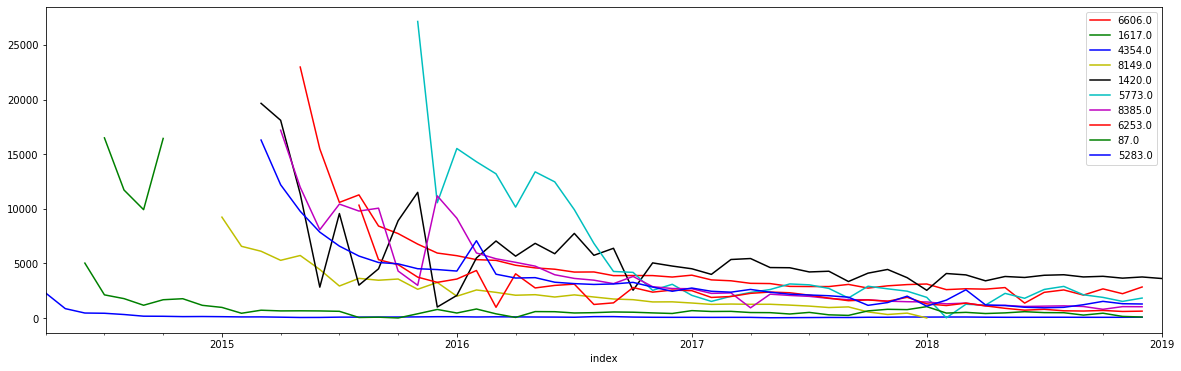

In [60]:
# Plot some random wells from df to see if the filter works out
np.random.seed(82)
random_wells_df = np.random.choice(df_filter.API.unique(), 10)

for well in random_wells_df:
    df_filter[(df_filter['API'] == well)]['Liquid'].plot(figsize=(20, 6))

plt.rc('axes', prop_cycle=(cycler('color', ['r', 'g', 'b', 'y', 'k', 'c', 'm', 'r', 'g', 'b', 'y', 'k', 'c', 'm','b','y'])))
plt.legend(random_wells_df)
plt.show()

#### Splitting data into train and test sets

In [282]:
# Create a batch for training set and define train data and test data. Due to the computer power limitations the model will be trained with only 100 wells
batch_well_train = np.random.choice(df_filter.API.unique()[:-1130], 200, replace=False)
df_f_train = df_filter[df_filter.API.isin(batch_well_train)]
df_f_test = df_filter[df_filter.API.isin(df_filter.API.unique()[-1130:])]

In [62]:
# Spliting training and test data into Y and EXO data sets 
Y_train_set = df_f_train.Liquid
exo_train_set = df_f_train.drop(['Liquid'], axis=1)
Y_test_set = df_f_test.Liquid
exo_test_set = df_f_test.drop(['Liquid'], axis=1)

### Complete exogenous variables with 36 observations given them are not going to change 

In [63]:
# Complete exogenous features of all wells with 36 observations
exo_test_set_d = pd.DataFrame()
exo_test_set_36m = pd.DataFrame(index=['index'], columns=exo_test_set.columns)

for well in exo_test_set.API.unique():
    index = []
    if len(exo_test_set[(exo_test_set.API == well)]) < 36:
        for p in range(36 - len(exo_test_set[(exo_test_set.API == well)])):
            i = datetime.fromtimestamp(datetime.timestamp(exo_test_set[(exo_test_set.API == well)].index.max() + relativedelta(months=p+1)))
            index.append(i)
            
            df_con = pd.DataFrame(index=index, columns=exo_test_set.columns)
            exo_test_set_36m = pd.concat([exo_test_set[(exo_test_set.API == well)], df_con], axis=0)
        
        exo_test_set_d = pd.concat([exo_test_set_d, exo_test_set_36m], axis=0)
    
    else:
        exo_test_set_d = pd.concat([exo_test_set_d,exo_test_set[(exo_test_set.API == well)]], axis=0)

In [64]:
# Fill new nan rows with the same data
exo_test_set_d = exo_test_set_d.fillna(method='ffill')

In [65]:
len(exo_test_set_d.API.unique())

1130

## 6. Modeling and forecatsing

### AUTOARIMA

In [67]:
# Set auto_arima model with train sets
mod_auar_li = auto_arima(Y_train_set, exogenous=exo_train_set[['API', 'operatorNameIHS_new', 'formation_new', 'BasinName_new', 'StateName_new', 'CountyName_new', 'BottomHoleLatitude_new','BottomHoleLongitude_new', 'LATERAL_LENGTH_BLEND_new', 'PROP_PER_FOOT_new', 'WATER_PER_FOOT_new']], m=5, max_p=5, max_q=5, max_P=5, max_Q=5, trend='ct')

#### - Forecast on test set

In [68]:
# Predict 36-month production for each well in train_API's without taking into account real values 
import warnings
warnings.filterwarnings("ignore")

results = []

for well in exo_test_set_d.API.unique():
    if len(exo_test_set[(exo_test_set.API == well)]) < 36:
        df_pred = pd.DataFrame(abs(mod_auar_li.predict(n_periods=len(exo_test_set_d[(exo_test_set_d.API == well)]) - len(exo_test_set[(exo_test_set.API == well)]), exogenous=exo_test_set_d[(exo_test_set_d.API == well)][['API', 'operatorNameIHS_new', 'formation_new', 
        'BasinName_new', 'StateName_new', 'CountyName_new', 'BottomHoleLatitude_new', 'BottomHoleLongitude_new', 'LATERAL_LENGTH_BLEND_new', 'PROP_PER_FOOT_new', 'WATER_PER_FOOT_new']][len(exo_test_set[(exo_test_set.API == well)])-len(exo_test_set_d[(exo_test_set_d.API == well)]):]))).values.sum()

        results.append(df_pred)
    
    else:
        results.append(df_f_test[(df_f_test.API == well)][:36].Liquid.sum())

In [69]:
# Appending the sum of real values that were not forecasted into the model
results_r = []
for well in df_f_test.API.unique():
    if len(df_f_test[(df_f_test.API == well)]) < 36:
        results_r.append(df_f_test[(df_f_test.API == well)].Liquid.values.sum())
    
    else:
        results_r.append(0)

#### - Add predicted values and real values

In [70]:
# Adding two columns predicted and real sums
results_final = [int(sum(i)) for i in zip(results, results_r)]

#### - Preparing dataset for final submission

In [71]:
# Drop duplicate values
test_APIs.drop_duplicates(inplace=True)

In [72]:
# Add a new column with the predicted values
test_APIs['Predicted'] = results_final

In [73]:
# Rename the columns as the competion Kaggle requires 
test_APIs.rename(columns={'API':'Id'}, inplace=True)

In [74]:
# Check how final set looks like
test_APIs.set_index(['Id'])

,Predicted
Id,
33025022600000,235506
33053059470100,189983
33053055610000,182606
33025015390100,199351
33061031960000,203238
...,...
42389342000000,129495
42389348570000,91150
42389340750000,104781


#### - Testing ARIMA model

In [77]:
# Get the wells with 36-month production in test_set
wells_all_obs = pd.DataFrame()

for i in exo_test_set.API.unique():
    if exo_test_set.API[(exo_test_set.API == i)].count() > 35:
        wells_all_obs = pd.concat([wells_all_obs, exo_test_set[(exo_test_set.API == i)]], axis=0)

In [78]:
test_set_exo = pd.DataFrame()
for well in wells_all_obs.API.unique():
    test_set_exo = pd.concat([test_set_exo, df_f_test[(df_f_test.API == well)][:36]],axis=0)

In [80]:
# Forecast the same wells using the model
test_pred = []
for well in test_set_exo.API.unique():
    test_b_pred = pd.DataFrame(mod_auar_li.predict(n_periods=36, exogenous=test_set_exo[(test_set_exo.API == well)]
    [['API', 'operatorNameIHS_new', 'formation_new', 'BasinName_new', 'StateName_new', 'CountyName_new', 'BottomHoleLatitude_new', 
    'BottomHoleLongitude_new', 'LATERAL_LENGTH_BLEND_new', 'PROP_PER_FOOT_new', 'WATER_PER_FOOT_new']])).values

    test_pred.append(test_b_pred)


In [81]:
test_pred = np.array(test_pred)
test_pred = test_pred.flatten()

In [82]:
test_set_exo['Liquid_pred'] = test_pred

In [83]:
test_set_exo['Liquid_pred'] = test_set_exo.Liquid_pred.replace([test_set_exo.Liquid_pred[:3]],[test_set_exo.Liquid[test_set_exo.API == 620][:3]])

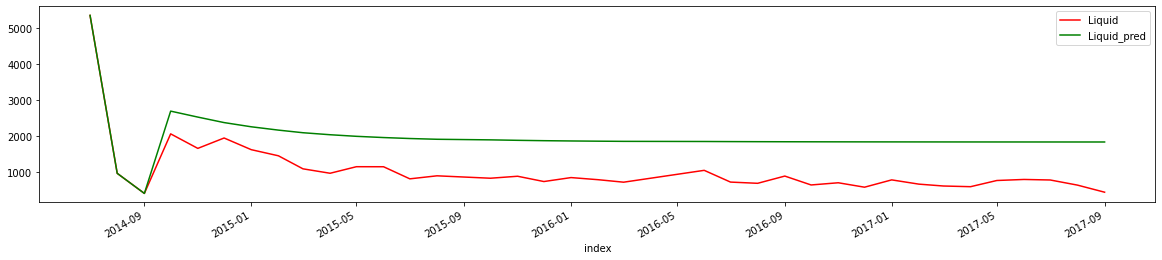

In [292]:
test_set_exo.Liquid[test_set_exo.API == 620].plot(figsize=(20,4))
test_set_exo.Liquid_pred[test_set_exo.API == 620].plot(figsize=(20,4))
plt.legend()
plt.show()

### XGBoost

#### - Ordering datasets by month's production rate

In [189]:
def order_month(df):
    df['prod_month_order'] = np.arange(len(df))
    return(df)

In [283]:
batch_well_train = np.random.choice(df_filter.API.unique()[:-1130], 1000, replace=False)
df_f_train = df_filter[df_filter.API.isin(batch_well_train)]
df_train_ord = df_f_train.groupby(df_f_train.API, as_index=True)
df_train_ord = df_train_ord.apply(order_month).sort_index()

In [273]:
batch_well_valid = np.random.choice(df_filter.API[(~df_filter.API.isin(batch_well_train))].unique(), 200)
df_f_valid = df_filter[df_filter.API.isin(batch_well_valid)]

In [277]:
df_valid_ord = df_f_valid.groupby(['API'], as_index=True)
df_valid_ord = df_valid_ord.apply(order_month).sort_index()

In [198]:
df_test_ord = exo_test_set_d.groupby(exo_test_set_d.API, as_index=True)
df_test_ord = df_test_ord.apply(order_month).sort_index()

#### - Plotting train data

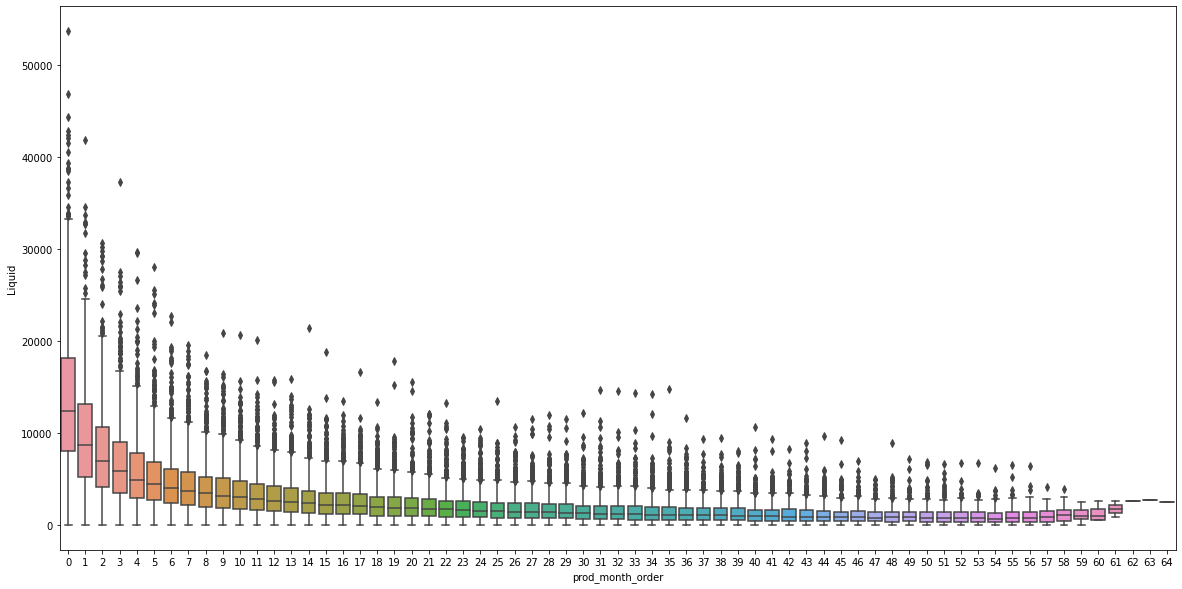

In [287]:
fig, ax = plt.subplots(figsize=(20,10))
sns.boxplot(data=df_train_ord, x=df_train_ord.prod_month_order, y=df_train_ord.Liquid)
plt.show()

#### - Split validation and train sets into X and Y

In [298]:
X_train_ord = df_train_ord.drop(['Liquid'], axis=1)
Y_train_ord = df_train_ord.Liquid

X_valid_ord = df_valid_ord.drop(['Liquid'], axis=1)
Y_valid_ord = df_valid_ord.Liquid

#### - Modeling with XGBoost Regressor

In [328]:
xgb_reg = xgb.XGBRegressor(n_estimators=1000, early_stopping_rounds=50, learning_rate=0.01).fit(X_train_ord,Y_train_ord, eval_set=[(X_train_ord, Y_train_ord),
(X_valid_ord, Y_valid_ord)], verbose=100)

[0]	validation_0-rmse:4456.85994	validation_1-rmse:4739.03613
[100]	validation_0-rmse:2528.57196	validation_1-rmse:2809.38165
[200]	validation_0-rmse:2003.31284	validation_1-rmse:2397.48004
[300]	validation_0-rmse:1832.22227	validation_1-rmse:2321.74224
[400]	validation_0-rmse:1747.90176	validation_1-rmse:2307.65350
[500]	validation_0-rmse:1689.63632	validation_1-rmse:2308.18667
[531]	validation_0-rmse:1672.47400	validation_1-rmse:2312.28713


#### - Feature Importance

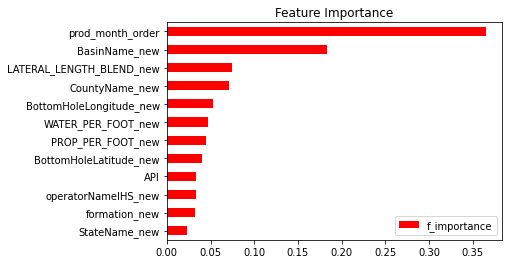

In [329]:
pd.DataFrame(xgb_reg.feature_importances_, index=xgb_reg.feature_names_in_, columns=['f_importance']).sort_values(by='f_importance').plot(kind='barh', title='Feature Importance');

#### - Forecast on Validation Data

In [330]:
Y_valid_pred = xgb_reg.predict(X_valid_ord)

In [331]:
df_valid_ord['Liquid_Pred'] = Y_valid_pred

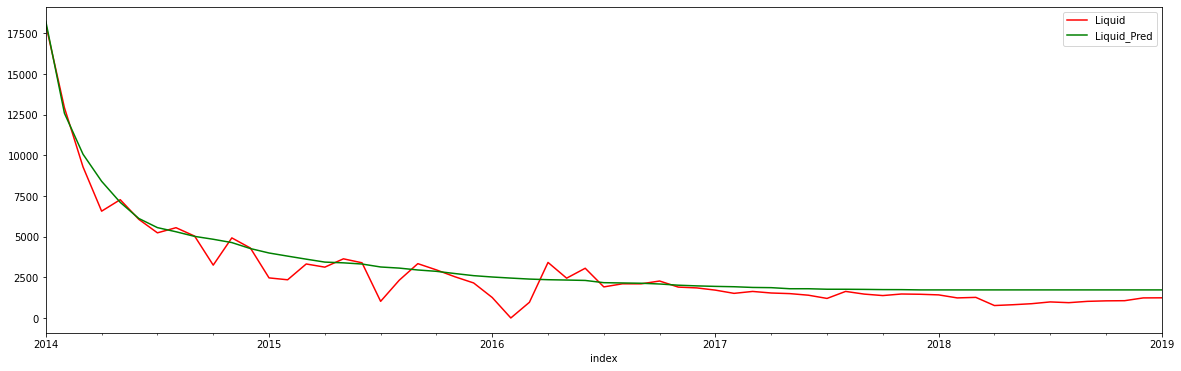

In [333]:
df_valid_ord.Liquid[df_valid_ord.API == 1761].plot(figsize =(20,6))
df_valid_ord.Liquid_Pred[df_valid_ord.API == 1761].plot()
plt.legend()
plt.show()